In [20]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [19]:
# ==== Main ======
import os
import pandas as pd
import numpy as np
# ==== display option ===============
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 400)
pd.set_option('display.min_rows', 10)
pd.set_option('display.expand_frame_repr', True)

In [13]:
# ==== Grafika i wykresy ==================
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
color = sns.color_palette()

In [21]:
# ==== DATA Preparation =================

from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit, learning_curve
from sklearn.base import clone
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report
from sklearn.metrics import average_precision_score, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import RobustScaler, StandardScaler

In [5]:
# Models

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb 

In [1]:
# Zbiór MNIST 70000 rysunków cyfr
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', cache=True)

In [2]:
X = mnist.data.values
y = mnist.target

In [3]:
X # 70000 obrazków i każdy ma 784 (28 x 28) cechy 

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:
y

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [5]:
y = y.astype(int)

In [6]:
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

In [8]:
some_number = X[69998]

In [9]:
some_number

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [10]:
some_number_image = some_number.reshape(28,28)

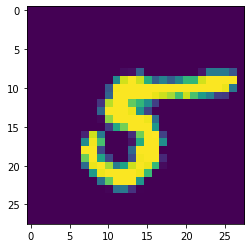

In [14]:
plt.imshow(some_number_image)

In [15]:
y[69998]

5

In [16]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:],y[:60000],y[60000:]

In [17]:
X_train.shape, y_train.shape

((60000, 784), (60000,))

In [22]:
# tasowanie danych - 
shuffle_index = np.random.permutation(60000)

In [23]:
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [24]:
# identyfikowanie binarne np 5 ! dwie klasy: jest 5 nie - to nie jest 5 
y_train_5 = np.where(y_train==5, 1, 0)
y_test_5 = np.where(y_test==5, 1, 0)

In [25]:
# wybierzmy jakiś prosty klasyfikator 
from sklearn.linear_model import SGDClassifier

In [26]:
sgd = SGDClassifier(random_state=43)
sgd.fit(X_train,y_train_5)

SGDClassifier(random_state=43)

In [28]:
sgd.predict([some_number])

array([1])

In [29]:
# ocenimy wydajność - ile % dobrze określił model 

from sklearn.model_selection import cross_val_score

cross_val_score(sgd, X_train, y_train_5, cv=3, scoring='accuracy')

### Dokładność powyżej 95% !!! 

Ale czy to dobrze ? 

Bądźmy jak na Titanicu - określmy, że wszyscy umarli ! tzn. napiszmy klasyfikator, który zawsze zwróci nie_5

In [ ]:
from sklearn.base import BaseEstimator

In [ ]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1))

### Jak myślisz jaka będzie dokładność takiego modelu ? 

In [ ]:
never_5 = Never5Classifier()
cross_val_score(never_5, X_train,y_train_5, cv=3, scoring='accuracy')

### Macierz pomyłek 

Znacznie lepszym sposobem oceny jakości klasyfikatora jest macierz pomyłek (confusion matrix)

W celu obliczenia macierzy wpierw trzeba otrzymać prognozy

Rząd reprezentuje rzeczywistą klasę, kolumna przewidywaną klasę. 

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd, X_train,y_train_5, cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

Prawidłowo sklasyfikowane = 52583 (niebędące piątką Prawdziwe Negatywne)

1996 = Fałszywie Pozytywne, 

1098 = Fałszywie Negatywne, oraz 

4323= Prawdziwie Pozytywne (będące piątkami)   

(Wyniki mogą być różne ze względu na funkcję zmieniającą indeksy)

$$Precyzja = \frac{PP}{PP+FP}$$ 

używana wraz z pełnością

$ Pelnosc= \frac{PP}{PP+FN} $, czułością lub odsetkiem pozytywnych

In [ ]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5,y_train_pred)

In [ ]:
4544/(4544+1469) # nie myli się w 75% 

In [ ]:
recall_score(y_train_5,y_train_pred) 

In [ ]:
4544/(4544+877) # rozpoznaje 83%

## Prawdziwe dane 

Zanonimizowane transakcje kart kredytowych w Europie z 2013 roku. 

Oznakowane jako autentyczne (0) i fraudowe (1) - proces klasyfikacji binarnej




In [ ]:
DATA_DIR = 'dane'
DATA_NAME = 'creditcard.csv'

In [ ]:
def load_csv_data():
    csv_path = os.path.join(DATA_DIR,DATA_NAME)
    return pd.read_csv(csv_path)

In [ ]:
df = load_csv_data()

In [ ]:
df['Class'].value_counts()

In [ ]:
sns.countplot(x='Class',data=df, palette='hls')
plt.show()

In [ ]:
df.info()

In [ ]:
df.head()

In [ ]:
df.sample(5)

In [ ]:
target = df['Class']

df2 = df.copy()
df2 = df2.drop(columns=['Time'])
df2 = df2.drop(columns=['Class','Unnamed: 0'])

In [ ]:
df2.describe()

In [ ]:
df3.info()

In [ ]:
distinctCounter = df3.apply(lambda x: len(x.unique()))

In [ ]:
df3.dtypes.value_counts()

In [ ]:
df2.isnull().any().any()

In [ ]:
df2.hist(bins=50,figsize=(20,15))
plt.show()

In [ ]:
### EDA

df['Amount'].hist(bins=50,figsize=(8,6))

In [ ]:
df[df['Class']==1]['Amount'].hist(bins=50,figsize=(8,6))

In [ ]:
corr_matrix = df2.corr()

In [ ]:
corr_matrix['Class'].sort_values(ascending=False)

In [ ]:
sns.heatmap(corr_matrix)

In [ ]:
!pip install Advanced-scorecard-builder

In [ ]:
from AmaFree import AdvancedScorecardBuilder as asb

In [ ]:
X = df2
t = asb(X,'Class')

In [ ]:
t.fit()

In [ ]:
t.get_scorecard()

In [ ]:
t.model_info_

In [ ]:
t.html_report('raport.html')

In [ ]:
# logistic regresion
penalty = 'l2' # mniej czułe na elementy odstające ni l1 - realizue stabilniejsze rozwiazanie
C = 1.0 # siła regularyzacji - im mniejsza C tym silniejsza regularyzacja
class_weight = 'balanced' # 
random_state = 2022
solver = 'liblinear'
logReg = LogisticRegression(penalty=penalty,
C=C, class_weight=class_weight, random_state=random_state,
solver=solver, n_jobs=-1)


